## author: Keer Mei
- github: kmei92
- email: keer.mei18@imperial.ac.uk

# Setup

In [1]:
# importing the necessary modules
import sys
sys.path.append("..")
from PDESystem import *
from PDESubsystem import *
from pdeforms import *

%load_ext autoreload
%autoreload 2

In [2]:
# a PDESystem child class called PDESolver. Note, the setup_constants function and setup_bcs are declared
# and overloaded here and the PDESystem's functions are not used. This is designed for clarity
class pde_solver(PDESystem):
    def __init__(self, comp, mesh, parameters):
        PDESystem.__init__(self, comp, mesh, parameters)

    def setup_bcs(self):
        h = fd.Constant(2.0)
        omega = fd.Constant(0.5)
        z0 = h*fd.cos(omega*self.t)
                
        bcz = [fd.DirichletBC(self.V['z'].sub(1), z0, 57)]
        self.bc['z'][1] = [bcz, z0, 57, 1, 'update']

    def setup_constants(self):
        x0 = 15
        y0 = 10
        L = 1.5
        x, y = fd.SpatialCoordinate(self.mesh)
        self.constants = {
            'deltat' : fd.Constant(self.prm['dt']),
            'D' : fd.Function(self.V['z']).sub(1).interpolate(fd.Constant(65)),
            'u_ext':fd.Function(self.V['z']).sub(0).interpolate(fd.as_vector((0.5, 0.0))),
            'h_ext': 0.0,
            'g' : 9.81, 
            'tau' : fd.Constant(0.001),
            'A' : fd.Constant(0.001),
            'n' : fd.FacetNormal(self.mesh),
            'boundary_marker' : 57,
            'boundary_marker2' : 58,
            'Kd' : fd.Constant(0.5),
            'k1' : fd.Constant(0.005),
            'k2' : fd.Constant(0.00005),
            'lamd1' : fd.Constant(0.000005),
            'lamd2' : fd.Constant(0.0),
            'rho_s' : fd.Constant(1.),
            'L' :  fd.Constant(1.),
            'phi' : fd.Constant(0.3),
            'f' : fd.Constant((0.0, 0.0)),
            'nu' : fd.Constant(0.001),
            'frac' : fd.Constant(1.),
            'source1' : fd.exp(-(pow((x-x0)/L,2)+pow((y-y0)/L,2)))
        }
        

# Solve

In [6]:
# update the parameters
solver_parameters = recursive_update(solver_parameters,
{
'space': {'z': [fd.VectorFunctionSpace, fd.FunctionSpace], # special function space
          'c': fd.MixedFunctionSpace, 'd' : fd.MixedFunctionSpace},
'family': {'z':'CG'},
'degree': {'z' : [1, 2]},
'order' : {'c': 3, 'd':3},
'dt' : 0.1,
'T' : 0.8}
)

#load mesh
mesh = fd.Mesh("../../meshes/gibraltar.msh")

# add subsystems for navier stokes and radio_transport
solver = pde_solver([['z']], mesh, solver_parameters)
solver.add_subsystem(['c', 'd'], solver_parameters)

#setup constants
solver.setup_constants()

# # define subsystems and variable sequence
solver.define(['z'], 'z', depth_avg_hydro_flather)
solver.define(['c', 'd'], 'cd', radio_transport_hydro)

# setup boundary conditions
solver.setup_bcs()
# solve
solver.solve(time_update=True)

# Plotting

## Pressure and Velocity

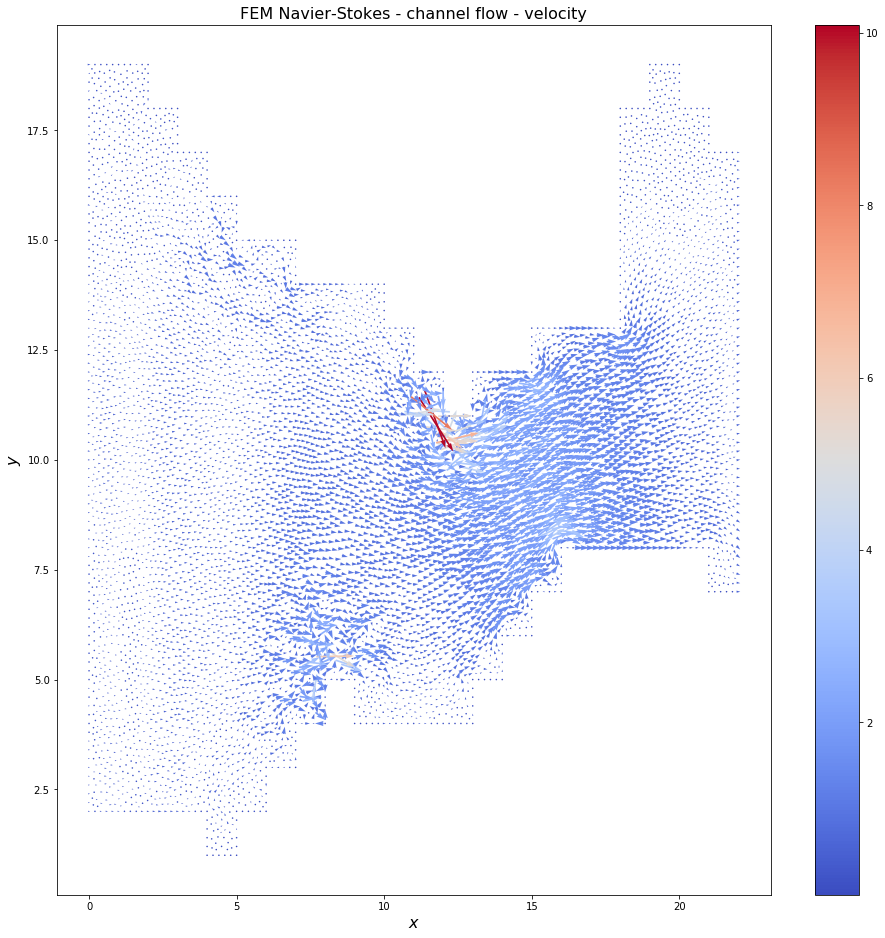

In [7]:
# Unlike the navier stokes equation, the velocity and water height are coupled into the same functionspace 
# when solving for the Shallow water equations. To plot individually, we have to split them 

u, h = solver.form_args['z_n'].split()

fig2 = plt.figure(figsize=(16, 16))
ax2 = fig2.add_subplot(111)
ax2.set_xlabel('$x$', fontsize=16)
ax2.set_ylabel('$y$', fontsize=16)
ax2.set_title('FEM Navier-Stokes - channel flow - velocity', fontsize=16)
fd.plot(u,axes=ax2)

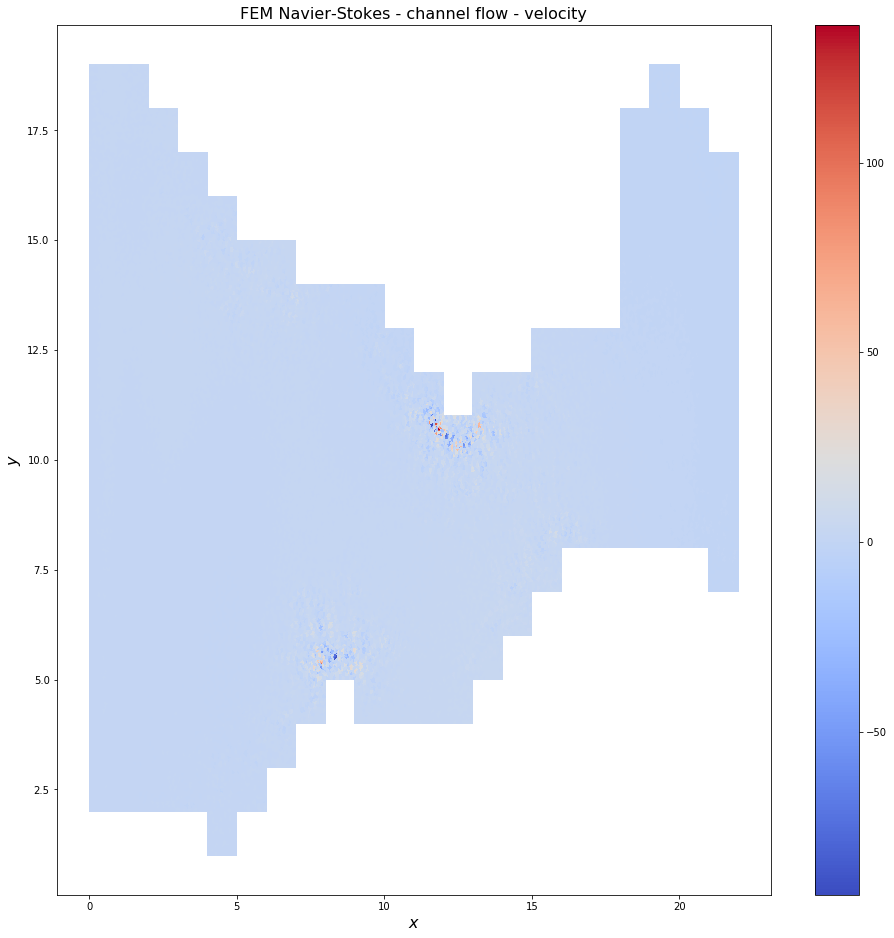

In [8]:
fig2 = plt.figure(figsize=(16, 16))
ax2 = fig2.add_subplot(111)
ax2.set_xlabel('$x$', fontsize=16)
ax2.set_ylabel('$y$', fontsize=16)
ax2.set_title('FEM Navier-Stokes - channel flow - velocity', fontsize=16)
fd.plot(h,axes=ax2)

## Plotting Radionuclide Concentration profiles

In [9]:
# since each phase contains two species and is a MixedFunctionSpace, use firedrake's split function
# to retrieve each subcomponent
cd, cs, csed = solver.form_args['c_'].split()
dd, ds, dsed = solver.form_args['d_'].split()

## Radionuclide 1 Concentration profile

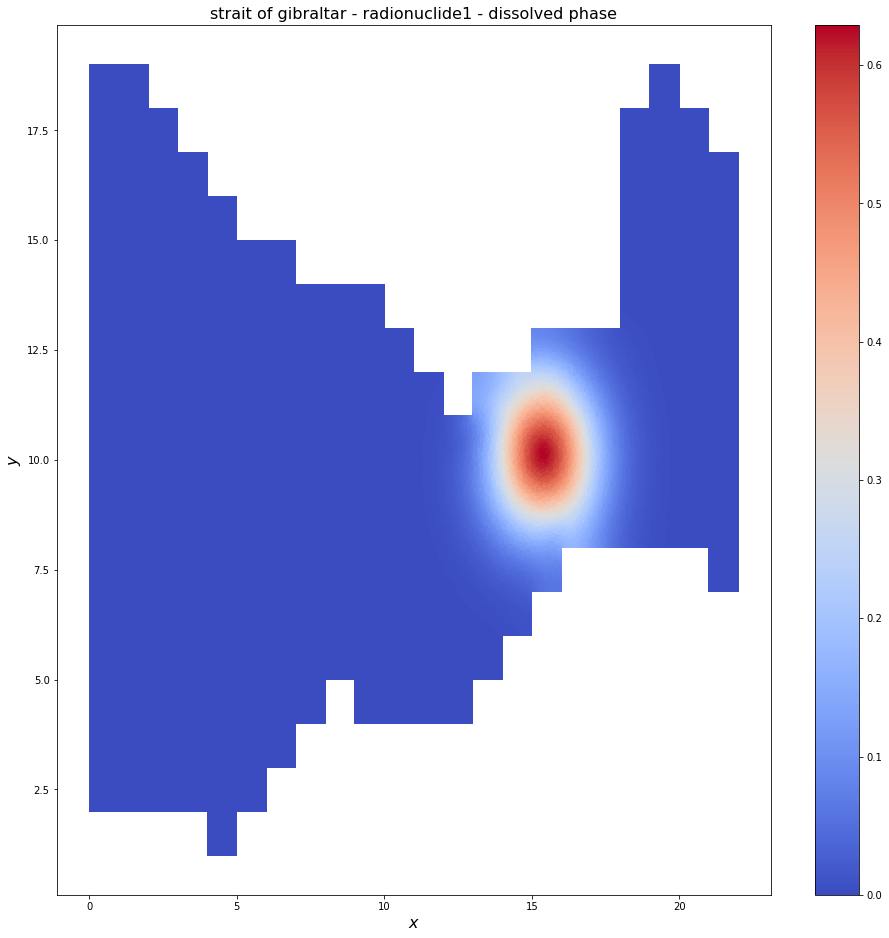

In [10]:
fig3 = plt.figure(figsize=(16, 16))
ax3 = fig3.add_subplot(111)
ax3.set_xlabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax3.set_title('strait of gibraltar - radionuclide1 - dissolved phase', fontsize=16)
fd.plot(cd,axes=ax3)

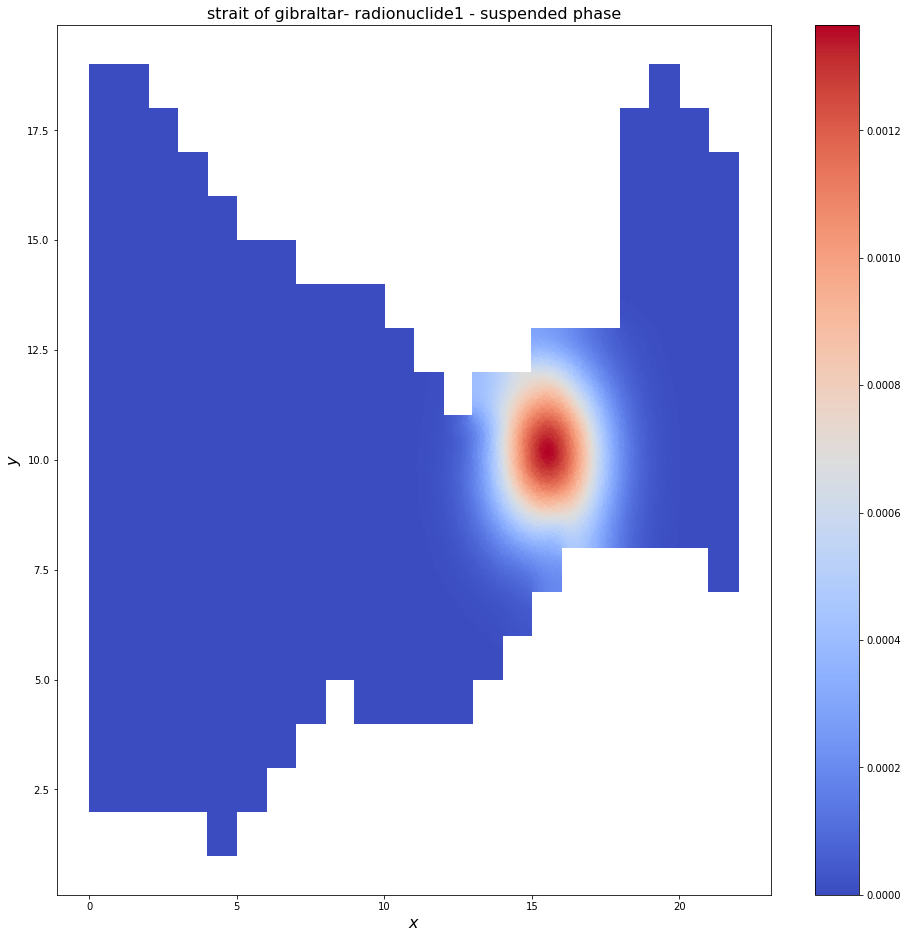

In [11]:
fig4 = plt.figure(figsize=(16, 16))
ax4 = fig4.add_subplot(111)
ax4.set_xlabel('$x$', fontsize=16)
ax4.set_ylabel('$y$', fontsize=16)
ax4.set_title('strait of gibraltar- radionuclide1 - suspended phase', fontsize=16)
fd.plot(cs, axes=ax4)

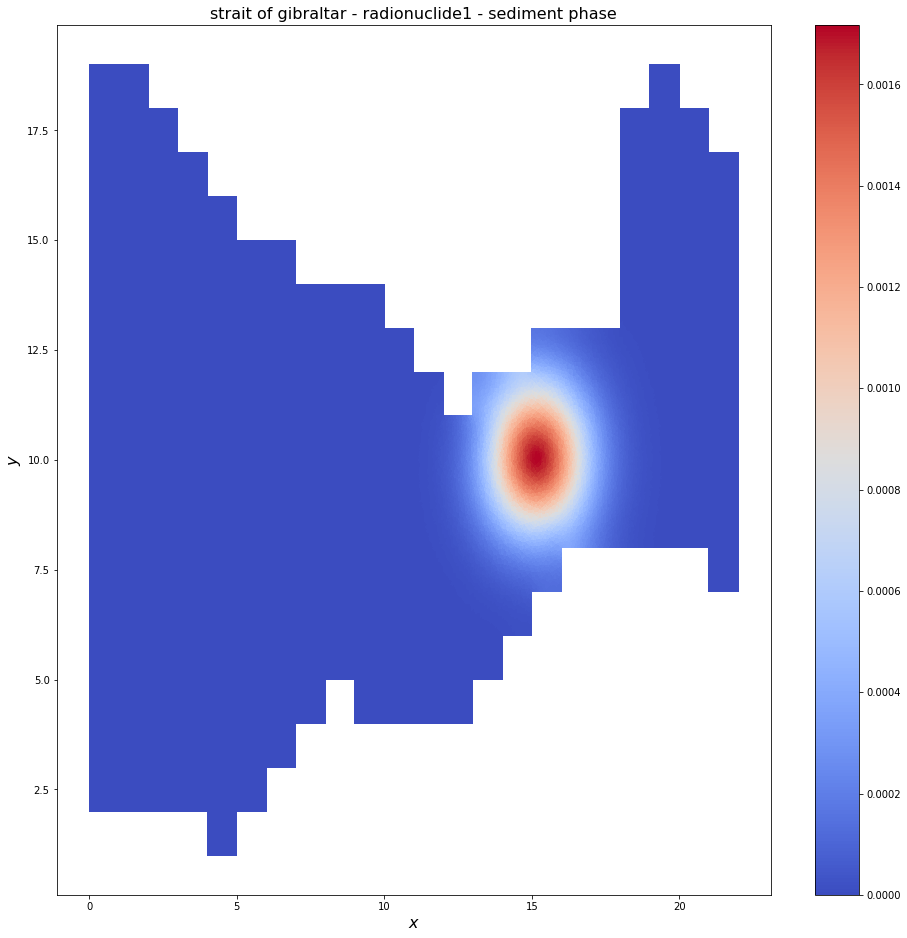

In [12]:
fig5 = plt.figure(figsize=(16, 16))
ax5 = fig5.add_subplot(111)
ax5.set_xlabel('$x$', fontsize=16)
ax5.set_ylabel('$y$', fontsize=16)
ax5.set_title('strait of gibraltar - radionuclide1 - sediment phase', fontsize=16)
fd.plot(csed, axes=ax5)

## Radionuclide 2 Concentration profile

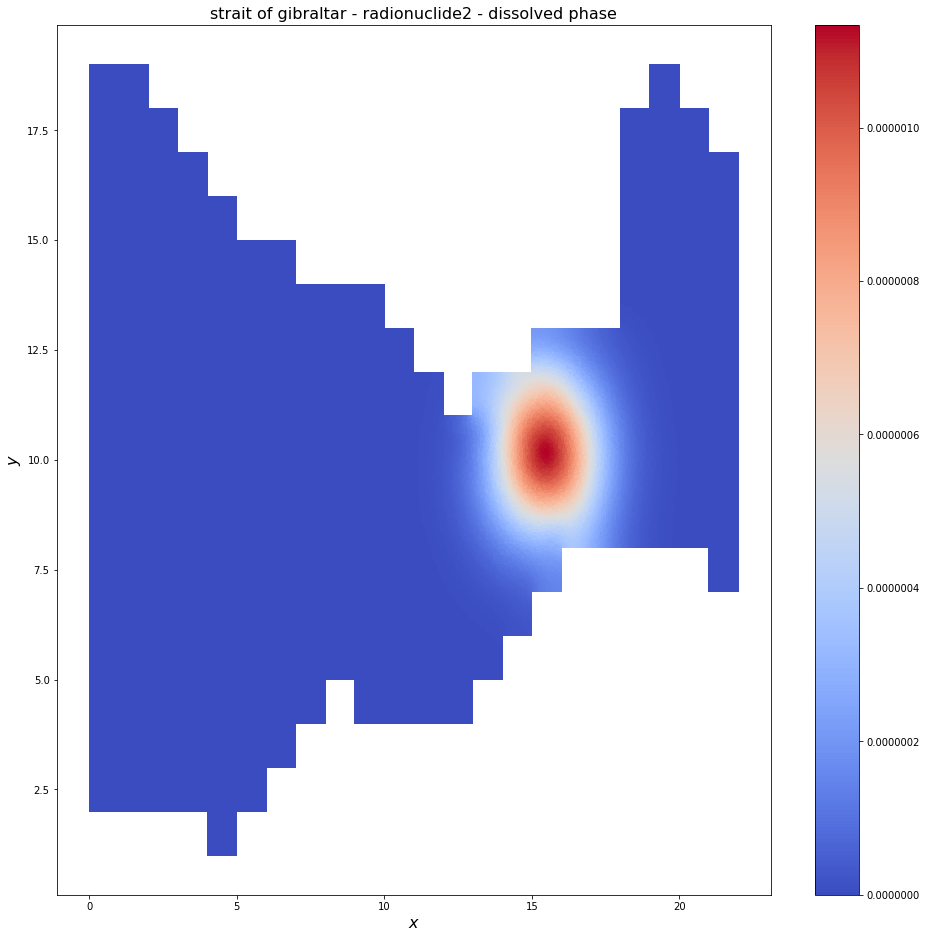

In [13]:
fig6 = plt.figure(figsize=(16, 16))
ax6 = fig6.add_subplot(111)
ax6.set_xlabel('$x$', fontsize=16)
ax6.set_ylabel('$y$', fontsize=16)
ax6.set_title('strait of gibraltar - radionuclide2 - dissolved phase', fontsize=16)
fd.plot(dd,axes=ax6)

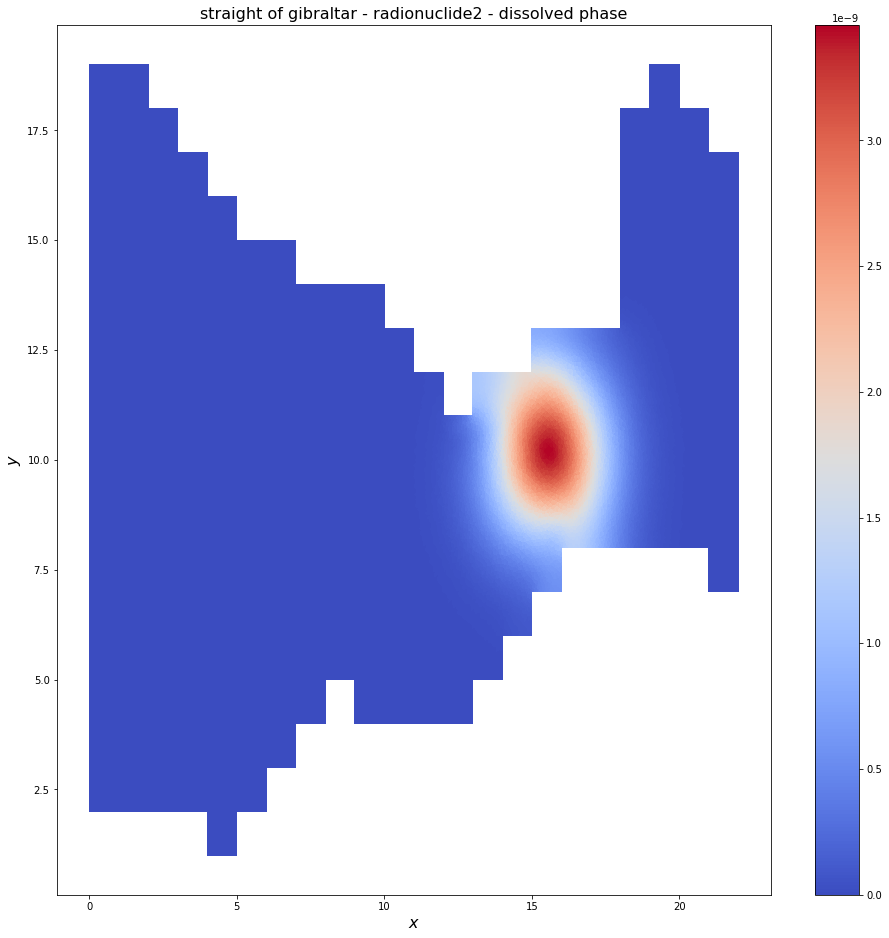

In [14]:
fig7 = plt.figure(figsize=(16, 16))
ax7 = fig7.add_subplot(111)
ax7.set_xlabel('$x$', fontsize=16)
ax7.set_ylabel('$y$', fontsize=16)
ax7.set_title('straight of gibraltar - radionuclide2 - dissolved phase', fontsize=16)
fd.plot(ds,axes=ax7)

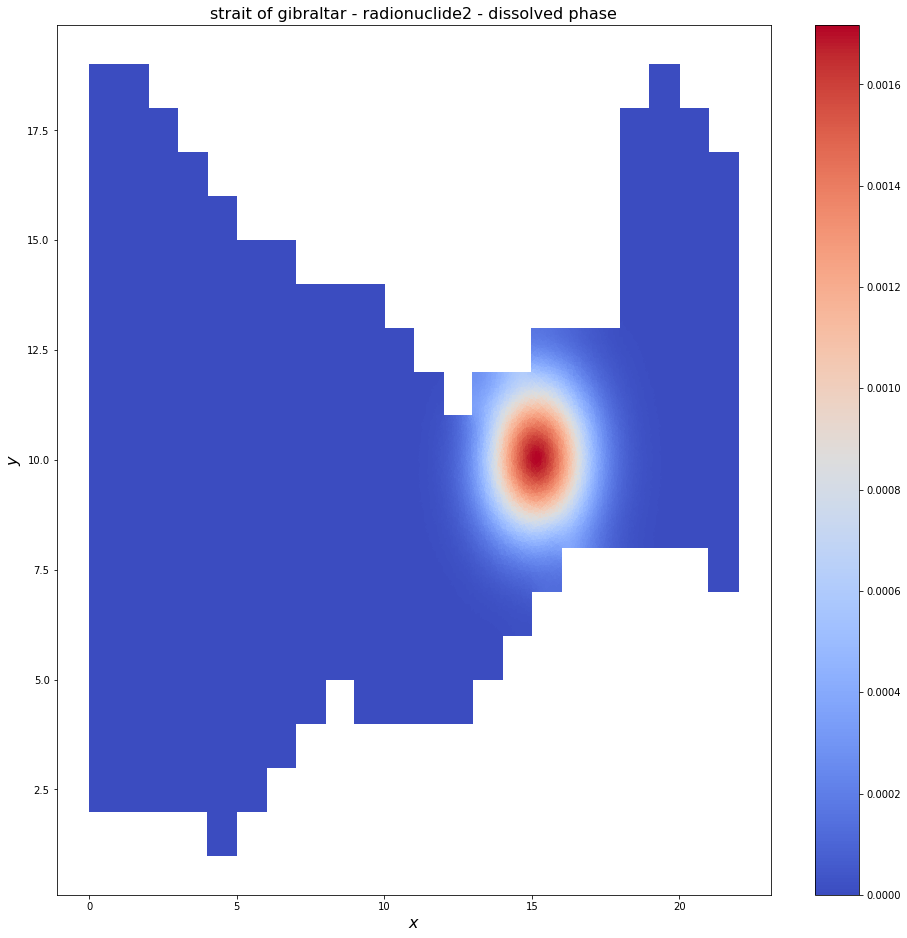

In [15]:
fig8 = plt.figure(figsize=(16, 16))
ax8 = fig8.add_subplot(111)
ax8.set_xlabel('$x$', fontsize=16)
ax8.set_ylabel('$y$', fontsize=16)
ax8.set_title('strait of gibraltar - radionuclide2 - dissolved phase', fontsize=16)
fd.plot(csed,axes=ax8)